<a href="https://colab.research.google.com/github/rahiakela/hands-on-unsupervised-learning-using-python/blob/main/4-anomaly-detection/01_credit_card_fraud_detection_using_linear_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Card Fraud Detection using Linear Anomaly Detection

Let’s build an applied machine learning solution using these dimensionality
reduction methods. We will build a credit card fraud detection system without using labels.

In the real world, fraud often goes undiscovered, and only the fraud that is
caught provides any labels for the datasets. Moreover, fraud patterns change over time, so supervised systems that are built using fraud labels—like the one we built using labels—become stale, capturing historical patterns of fraud but
failing to adapt to newly emerging patterns.

For these reasons (the lack of sufficient labels and the need to adapt to newly
emerging patterns of fraud as quickly as possible), unsupervised learning fraud
detection systems are in vogue.



##Setup

In [18]:
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample

# principal components
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

# Suppress warnings
pd.set_option('mode.chained_assignment', None)

Let's download creditcardfraud dataset from [Kaggle](https://www.kaggle.com/isaikumar/creditcardfraud).

In [2]:
from google.colab import files
files.upload() # upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahiakela","key":"484f91b2ebc194b0bff8ab8777c1ebff"}'}

In [3]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download word embeddings from kaggle
kaggle datasets download -d isaikumar/creditcardfraud
unzip -qq creditcardfraud.zip
rm -rf creditcardfraud.zip

kaggle.json
 97% 64.0M/65.9M [00:00<00:00, 89.1MB/s]
100% 65.9M/65.9M [00:00<00:00, 104MB/s] 


##Prepare the Data

Let’s load the credit card transactions dataset, generate
the features matrix and labels array, and split the data into training and test sets. We will not use the labels to perform anomaly detection, but we will use the labels to help evaluate the fraud detection systems we build.

As a reminder, we have 284,807 credit card transactions in total, of which 492
are fraudulent, with a positive (fraud) label of one. The rest are normal
transactions, with a negative (not fraud) label of zero.

We have 30 features to use for anomaly detection—time, amount, and 28
principal components. And, we will split the dataset into a training set (with
190,820 transactions and 330 cases of fraud) and a test set (with the remaining
93,987 transactions and 162 cases of fraud):

In [4]:
# Load datasets
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Count total fraud
print("Number of fraudulent transactions:", data["Class"].sum())

Number of fraudulent transactions: 492


In [6]:
# Split to train and test and scale features
data_x = data.drop(["Class"], axis=1)
data_y = data.loc[:, "Class"].copy()

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=2020, stratify=data_y)

features_to_scale = x_train.columns
sx = pp.StandardScaler(copy=True)
x_train.loc[:, features_to_scale] = sx.fit_transform(x_train.loc[:, features_to_scale])
x_test.loc[:, features_to_scale] = sx.fit_transform(x_test.loc[:, features_to_scale])

###Define Anomaly Score Function

As we know, dimensionality reduction algorithms
reduce the dimensionality of data while attempting to minimize the
reconstruction error. In other words, these algorithms try to capture the most
salient information of the original features in such a way that they can
reconstruct the original feature set from the reduced feature set as well as
possible. 

However, these dimensionality reduction algorithms cannot capture all
the information of the original features as they move to a lower dimensional
space; therefore, there will be some error as these algorithms reconstruct the reduced feature set back to the original number of dimensions.

In the context of our credit card transactions dataset, the algorithms will have the
largest reconstruction error on those transactions that are hardest to model—in
other words, those that occur the least often and are the most anomalous. Since
fraud is rare and presumably different than normal transactions, the fraudulent
transactions should exhibit the largest reconstruction error.

So let’s define the
anomaly score as the reconstruction error. The reconstruction error for each
transaction is the sum of the squared differences between the original feature
matrix and the reconstructed matrix using the dimensionality reduction
algorithm. 

We will scale the sum of the squared differences by the max-min
range of the sum of the squared differences for the entire dataset, so that all the reconstruction errors are within a zero to one range.

The transactions that have the largest sum of squared differences will have an
error close to one, while those that have the smallest sum of squared differences will have an error close to zero.

In [7]:
# Calculate reconstruction error
def anomaly_scores(original_df, reduced_df):
  loss = np.sum((np.array(original_df) - np.array(reduced_df)) ** 2, axis=1)
  loss = pd.Series(data=loss, index=original_df.index)
  loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))

  return loss

###Define Evaluation Metrics

Although we will not use the fraud labels to build the unsupervised fraud
detection solutions, we will use the labels to evaluate the unsupervised solutions
we develop. The labels will help us understand just how well these solutions are
at catching known patterns of fraud.

In [8]:
# Plot results
def plot_results(trueLabels, anomalyScores, returnPreds = False):
  preds = pd.concat([trueLabels, anomalyScores], axis=1)
  preds.columns = ['trueLabel', 'anomalyScore']
  precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
  average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
  
  plt.step(recall, precision, color='k', alpha=0.7, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  
  plt.title('Precision-Recall curve: Average Precision = \
  {0:0.2f}'.format(average_precision))

  fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                    preds['anomalyScore'])
  areaUnderROC = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic: \
  Area under the curve = {0:0.2f}'.format(areaUnderROC))
  plt.legend(loc="lower right")
  plt.show()
  
  if returnPreds==True:
      return preds

###Define Plotting Function

We will use the scatterplot function to display the separation of points the dimensionality reduction algorithm achieves in just the first two dimensions:

In [9]:
# View scatterplot
def scatterPlot(xDF, yDF, algoName):
  tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
  tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
  tempDF.columns = ["First Vector", "Second Vector", "Label"]
  sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Separation of Observations using "+algoName)

##Normal PCA

We will now use PCA to learn the underlying structure of the credit card transactions dataset. Once we learn this structure, we will use
the learned model to reconstruct the credit card transactions and then calculate
how different the reconstructed transactions are from the original transactions.
Those transactions that PCA does the poorest job of reconstructing are the most
anomalous (and most likely to be fraudulent).

As
we’ve defined it, anomaly detection relies on reconstruction error. We want the
reconstruction error for rare transactions—the ones that are most likely to be
fraudulent—to be as high as possible and the reconstruction error for the rest to be as low as possible.

For PCA, the reconstruction error will depend largely on the number of principal
components we keep and use to reconstruct the original transactions. The more
principal components we keep, the better PCA will be at learning the underlying
structure of the original transactions.

However, there is a balance. If we keep too many principal components, PCA
may too easily reconstruct the original transactions, so much so that the
reconstruction error will be minimal for all of the transactions. If we keep too
few principal components, PCA may not be able to reconstruct any of the
original transactions well enough—not even the normal, nonfraudulent
transactions.

###PCA Components Equal Number of Original Dimensions

If we use PCA to generate the same number of principal components as the number of original features, will we be able to perform anomaly detection?

When the number of principal components equals the number of original
dimensions, PCA captures nearly 100% of the variance/information in the data
as it generates the principal components. 

Therefore, when PCA reconstructs the transactions from the principal components, it will have too little reconstruction
error for all the transactions, fraudulent or otherwise. We will not be able to
differentiate between rare transactions and normal ones—in other words,
anomaly detection will be poor.

To highlight this, let’s apply PCA to generate the same number of principal
components as the number of original features (30 for our credit card
transactions dataset).

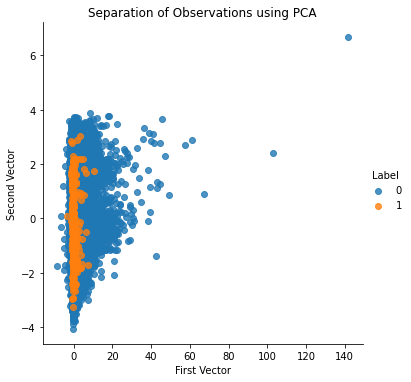

In [10]:
n_components = 30
whiten = False
random_state = 2020

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

x_train_pca = pca.fit_transform(x_train)
x_train_pca = pd.DataFrame(data=x_train_pca, index=x_train.index)

# To reconstruct the original transactions from the generated principal components
x_train_pca_inverse = pca.inverse_transform(x_train_pca)
x_train_pca_inverse = pd.DataFrame(data=x_train_pca_inverse, index=x_train.index)

scatterPlot(x_train_pca, y_train, "PCA")

Let’s calculate the precision-recall curve and the ROC curve.

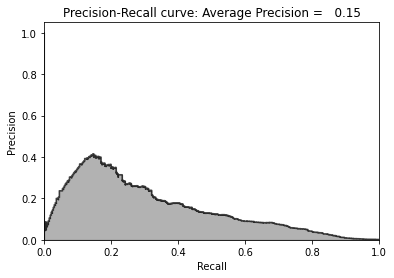

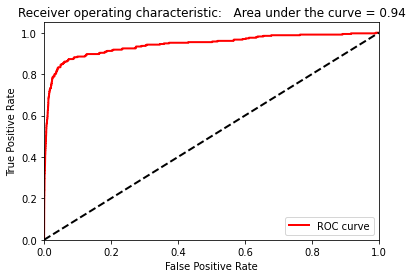

In [11]:
anomalyScoresPCA = anomaly_scores(x_train, x_train_pca_inverse)
preds = plot_results(y_train, anomalyScoresPCA, True)

With an average precision of 0.11, this is a poor fraud detection solution.It catches very little of the fraud.

###Search for the Optimal Number of Principal Components

Now, let’s perform a few experiments by reducing the number of principal
components PCA generates and evaluate the fraud detection results. We need the
PCA-based fraud detection solution to have enough error on the rare cases that it
can meaningfully separate fraud cases from the normal ones. But the error
cannot be so low or so high for all the transactions that the rare and normal
transactions are virtually indistinguishable.

After some experimentation,we find that 27 principal components is the optimal number for this credit card transactions dataset.

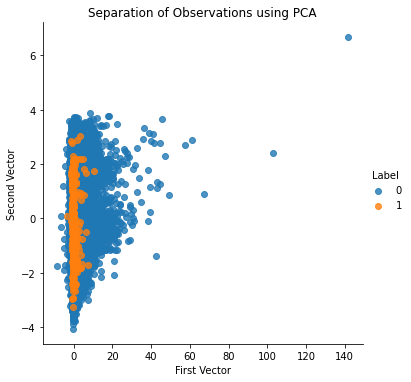

In [12]:
n_components = 27
whiten = False
random_state = 2020

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(x_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=x_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=x_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

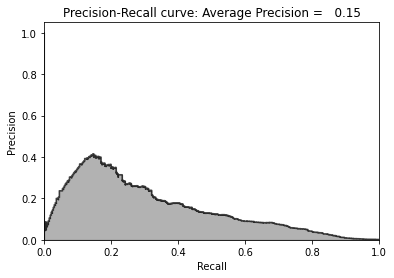

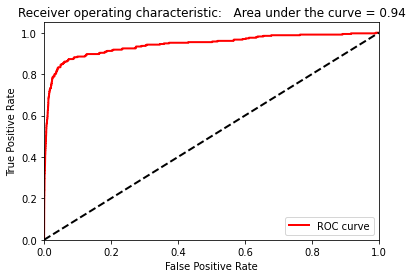

In [13]:
anomaly_scores_pca = anomaly_scores(x_train, x_train_pca_inverse)
preds = plot_results(y_train, anomaly_scores_pca, True)

As you can see, we are able to catch 80% of the fraud with 75% precision. This
is very impressive considering that we did not use any labels. To make these
results more tangible, consider that there are 190,820 transactions in the training set and only 330 are fraudulent.

Using PCA, we calculated the reconstruction error for each of these 190,820
transactions. If we sort these transactions by highest reconstruction error (also
referred to as anomaly score) in descending order and extract the top 350
transactions from the list, we can see that 264 of these transactions are
fraudulent.

That is a precision of 75%. Moreover, the 264 transactions we caught from the
350 we picked represent 80% of the total fraud in the training set (264 out of 330 fraudulent cases). And, remember that we accomplished this without using
labels. This is a truly unsupervised fraud detection solution.

In [14]:
#  Analyze results
preds.sort_values(by="anomalyScore", ascending=False, inplace=True)
cutoff = 350
top_preds = preds[:cutoff]

print("Precision: ", np.round(top_preds.anomalyScore[top_preds.trueLabel==1].count() / cutoff, 2))
print("Recall: ", np.round(top_preds.anomalyScore[top_preds.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", top_preds.trueLabel.sum())

Precision:  0.26
Recall:  0.28
Fraud Caught out of 330 Cases: 91


In [15]:
# Select all 330 fraud and 2000 non-fraud
fraud_indices = y_train[y_train==1].index
non_fraud_indices = resample(y_train[y_train==0], n_samples=2000, random_state=2021).index
sample_indices = fraud_indices.append(non_fraud_indices)

In [16]:
# Log data
!mkdir logs
!mkdir logs/04_anomaly_detection_credit_card_fraud

log_dir = "logs/04_anomaly_detection_credit_card_fraud/"
y_train[sample_indices].to_csv(log_dir+'labels.tsv', sep = '\t', index=False, header=False)

In [17]:
# Write dimensions to TSV
x_train_pca.loc[sample_indices,:].to_csv(log_dir+'pca_data.tsv', sep = '\t', index=False, header=False)

##Sparse PCA

Sparse PCA is similar to normal PCA but delivers a less dense version; in other
words, sparse PCA provides a sparse representation of the principal components.

Note that for normal PCA Scikit-Learn used a fit_transform function to
generate the principal components and an inverse_transform function to
reconstruct the original dimensions from the principal components. Using these
two functions, we were able to calculate the reconstruction error between the
original feature set and the reconstructed feature set derived from the PCA.

Unfortunately, Scikit-Learn does not provide an inverse_transform function for sparse PCA. Therefore, we must reconstruct the original dimensions after we
perform sparse PCA ourselves.

Let’s begin by generating the sparse PCA matrix with 27 principal components
and the default alpha parameter of 0.0001:

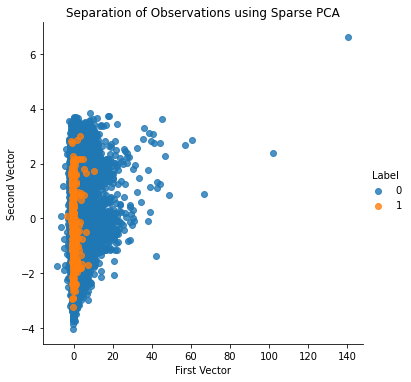

In [37]:
n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(x_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(x_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=x_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

Now let’s generate the original dimensions from the sparse PCA matrix by
simple matrix multiplication of the sparse PCA matrix (with 190,820 samples
and 27 dimensions) and the sparse PCA components (a 27 x 30 matrix), provided
by Scikit-Learn library. 

This creates a matrix that is the original size (a 190,820
x 30 matrix). We also need to add the mean of each original feature to this new
matrix, but then we are done.

From this newly derived inverse matrix, we can calculate the reconstruction
errors (anomaly scores) as we did with normal PCA:

In [38]:
x_train.shape

(190820, 30)

In [39]:
X_train_sparse_PCA_inverse.shape

(190820, 27)

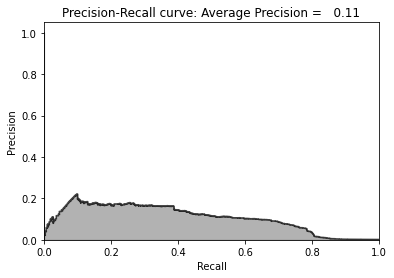

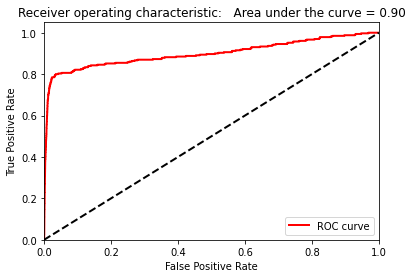

In [42]:
# View plot
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA).dot(sparsePCA.components_) + np.array(x_train.mean(axis=0))
X_train_sparsePCA_inverse = pd.DataFrame(data=X_train_sparsePCA_inverse, index=x_train.index)

anomalyScoresSparsePCA = anomaly_scores(x_train, X_train_sparsePCA_inverse)
preds = plot_results(y_train, anomalyScoresSparsePCA, True)

##Kernel PCA